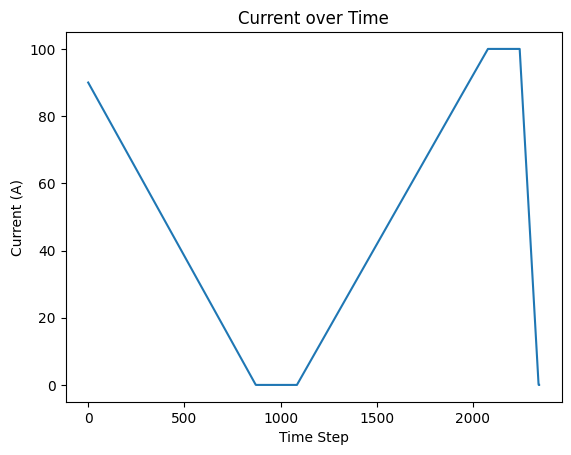

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load the data from the CSV file
data = pd.read_csv('/content/DATALG.csv')

# Extract the current values
current = data["SOC"]

# Plot the data
plt.plot(current)
plt.title('Current over Time')
plt.xlabel('Time Step')
plt.ylabel('Current (A)')
plt.show()


In [ ]:
# Perform ADF test for stationarity
result = adfuller(current)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_current = scaler.fit_transform(np.array(current).reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_current) * 0.7)
train_data, test_data = scaled_current[:train_size], scaled_current[train_size:]


ADF Statistic: -2.3996415381053438
p-value: 0.14183760746945184
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [ ]:
# Define sequence length
seq_length = 30

# Create sequences for training and testing
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [ ]:
# Reshape the input data for 1D CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Build the 1D CNN model
import tensorflow as tf
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy','mean_absolute_error',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
print(model.summary())
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 28, 64)            256       
                                                                 
 conv1d_7 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 832)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                41650     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [ ]:
# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


22/22 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.2507 - mean_absolute_error: 0.0249    
Test Loss: [0.001307058846578002, 0.2507418394088745, 0.024863438680768013]


In [ ]:
# Make predictions on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


22/22 [==============================] - 0s 1ms/step


In [ ]:
# Calculate MSE and MAE for train and test data
train_mse = mean_squared_error(scaler.inverse_transform(y_train), train_predict)
test_mse = mean_squared_error(scaler.inverse_transform(y_test), test_predict)
train_mae = mean_absolute_error(scaler.inverse_transform(y_train), train_predict)
test_mae = mean_absolute_error(scaler.inverse_transform(y_test), test_predict)

print('Train MSE:', train_mse)
print('Test MSE:', test_mse)
print('Train MAE:', train_mae)
print('Test MAE:', test_mae)


Train MSE: 0.5256525450580305
Test MSE: 13.070596366867425
Train MAE: 0.6400782347960633
Test MAE: 2.4863468916697253


In [ ]:
# Save test predictions to a CSV file
test_predictions_df = pd.DataFrame({'Test Ground Truth': scaler.inverse_transform(y_test).flatten(),
                                    'Test Predictions': test_predict.flatten()})
test_predictions_df.to_csv('test_predictions_Current.csv', index=False)

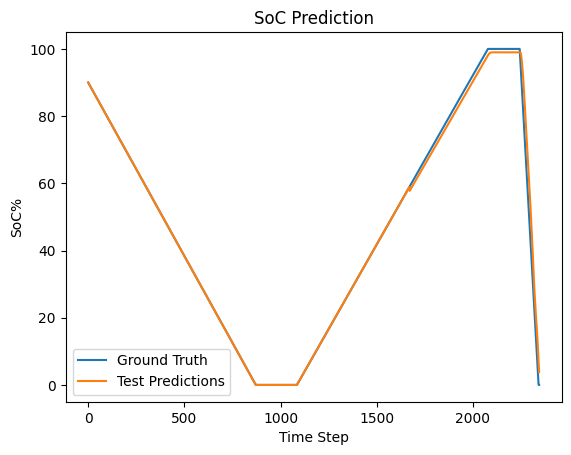

In [ ]:
# Plot the ground truth and predicted current values
plt.plot(current.values, label='Ground Truth')
plt.plot(np.concatenate([current[:train_size + seq_length].values.reshape(-1), test_predict.reshape(-1)]), label='Test Predictions')
plt.title('SoC Prediction')
plt.xlabel('Time Step')
plt.ylabel('SoC%')
plt.legend()
plt.show()


1/1 [==============================] - 0s 14ms/step


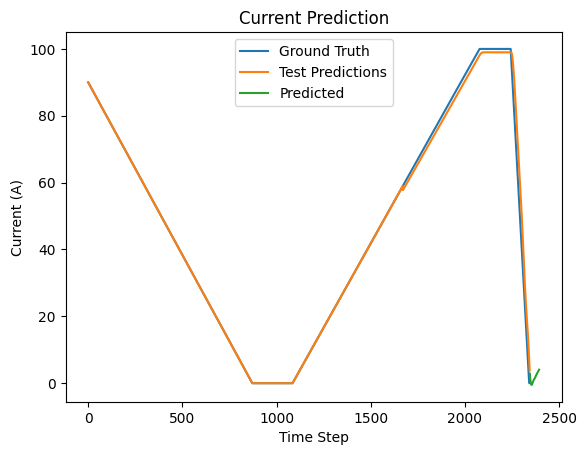

In [ ]:
# Define the number of predictions
pred_length = 50

# Make predictions for the next 50 current values
last_sequence = np.copy(test_data[-seq_length:])
predicted_values = []
for _ in range(pred_length):
    prediction = model.predict(last_sequence.reshape(1, seq_length, 1))
    predicted_values.append(prediction[0])
    last_sequence = np.concatenate((last_sequence[1:], prediction))

# Transform predicted values back to the original scale
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

# Plot the ground truth and predicted values
plt.plot(current.values, label='Ground Truth')
plt.plot(np.concatenate([current[:train_size + seq_length].values.reshape(-1), test_predict.reshape(-1)]), label='Test Predictions')
plt.plot(np.arange(len(current), len(current) + pred_length), predicted_values, label='Predicted')
plt.title('Current Prediction')
plt.xlabel('Time Step')
plt.ylabel('Current (A)')
plt.legend()
plt.show()
